In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
#import eli5
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
from tqdm import tqdm
import train
import robustify

from sklearn import decomposition
import matplotlib.gridspec as grd

Using TensorFlow backend.
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/linux/anaconda3.7/lib/pytho

In [14]:
df = data_tracks.get_data()
n = df.shape[0]
df.keys()

Index(['X', 'Y', 'X_pvals', 'Y_pvals', 'pixel', 'pixel_left', 'pixel_right',
       'pixel_up', 'pixel_down', 'catIdx', 'total_displacement',
       'mean_square_displacement', 'lifetime', 'x_pos', 'y_pos', 'center_max',
       'left_max', 'right_max', 'up_max', 'down_max', 'cell_num', 'X_max',
       'X_min', 'X_mean', 'X_std', 'Y_max', 'Y_mean', 'Y_std', 'rise', 'fall',
       'max_diff', 'min_diff', 'y_score', 'y_thresh', 'y', 'y_single_sig',
       'y_double_sig', 'y_consec_sig', 'sc_0', 'sc_1', 'sc_2', 'sc_3', 'sc_4',
       'sc_5', 'sc_6', 'sc_7', 'sc_8', 'sc_9', 'sc_10', 'sc_11', 'nmf_0',
       'nmf_1', 'nmf_2', 'nmf_3', 'nmf_4', 'nmf_5', 'nmf_6', 'nmf_7', 'nmf_8',
       'nmf_9', 'nmf_10', 'nmf_11', 'X_smooth_spl', 'X_smooth_spl_dx',
       'X_smooth_spl_d2x', 'X_max_spl', 'dx_max_spl', 'd2x_max_spl',
       'num_local_max_spl', 'num_local_min_spl'],
      dtype='object')

### Robustness of X_max

In [9]:
X_max_rb = robustify.robust_measure(df, np.max)
def quantile_95(x):
    return np.quantile(x, 0.95)
X_qt_95_rb = robustify.robust_measure(df, quantile_95)

Text(0.5, 0, 'sd of noise')

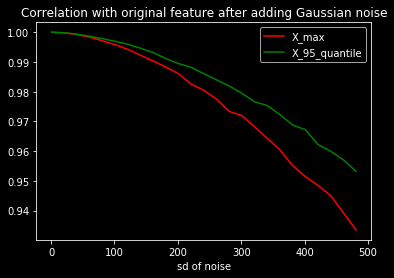

In [17]:
plt.plot(range(1, 500, 20), X_max_rb, color='red', label='X_max')
plt.plot(range(1, 500, 20), X_qt_95_rb, color='green', label='X_95_quantile')
plt.legend()
plt.title('Correlation with original feature after adding Gaussian noise')
plt.xlabel('sd of noise')

### Robustness of X_std

In [18]:
def interquantile(x):
    return np.quantile(x, 0.75) - np.quantile(x, 0.25)
X_std_rb = robustify.robust_measure(df, np.std)
X_iqr_rb = robustify.robust_measure(df, interquantile)

In [4]:
from statsmodels import robust
#X_mad_rb = robustify.robust_measure(df, robust.mad)

Text(0.5, 0, 'sd of noise')

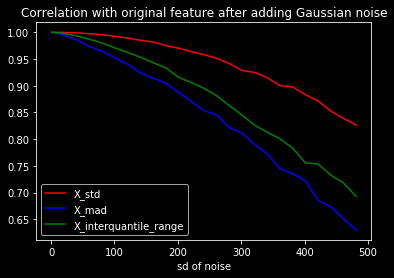

In [27]:
plt.plot(range(1, 500, 20), X_std_rb, color='red', label='X_std')
plt.plot(range(1, 500, 20), X_mad_rb, color='blue', label='X_mad')
plt.plot(range(1, 500, 20), X_iqr_rb, color='green', label='X_interquantile_range')
plt.legend()
plt.title('Correlation with original feature after adding Gaussian noise')
plt.xlabel('sd of noise')

### Robustness of rise and fall

In [21]:
def calc_rise(x):
    idx_max = np.argmax(x)
    val_max = x[idx_max]
    rise = val_max - np.min(x[:idx_max + 1]) # max change before peak
    return rise

In [22]:
def calc_fall(x):
    idx_max = np.argmax(x)
    val_max = x[idx_max]
    fall = val_max - np.min(x[idx_max:]) # drop after peak
    return fall

In [23]:
X_rise_rb = robustify.robust_measure(df, calc_rise)
X_fall_rb = robustify.robust_measure(df, calc_fall)

Text(0.5, 0, 'sd of noise')

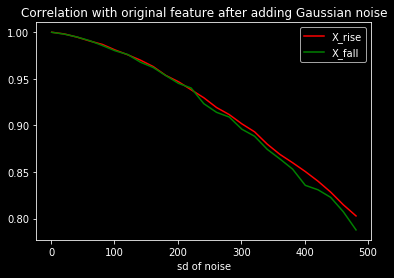

In [24]:
plt.plot(range(1, 500, 20), X_rise_rb, color='red', label='X_rise')
plt.plot(range(1, 500, 20), X_fall_rb, color='green', label='X_fall')
plt.legend()
plt.title('Correlation with original feature after adding Gaussian noise')
plt.xlabel('sd of noise')

In [751]:
def interquantile(x):
    return np.quantile(x, 0.75) - np.quantile(x, 0.25)

In [15]:
df['mad'] = np.array([robust.mad(df.iloc[i].X) for i in range(len(df))])

In [16]:
feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 
              'rise', 'fall', 'mad']
outcome_def = 'y_consec_sig'
out_dir = f'results_afterpeak/outcome={outcome_def}'
os.makedirs(out_dir, exist_ok=True)
for feature_selection in ['select_rf']: #, 'select_lasso']: # select_lasso
    for balancing in ['ros']: # none
        for model_type in tqdm(['logistic', 'dt', 'rf', 'mlp2', 'dt', 'svm']): #,'gb', 'logistic', 'dt', 'svm', 'gb', rf', 'mlp2', 'irf']):
            for num_feats in [7]: # number of total features to consider
                for feature_selection_num in [7]: # number of feature to select [4, 9, 11, 23, 35, 39]
                    feats = feat_names[:num_feats]
                    out_name = f'{model_type}_{num_feats}_{balancing}_{feature_selection}={feature_selection_num}'
                    #print(out_name)
                    train.train(df, feat_names=feats, model_type=model_type, 
                                balancing=balancing, outcome_def=outcome_def,
                                feature_selection=feature_selection,
                                feature_selection_num=feature_selection_num,
                                out_name=f'{out_dir}/{out_name}.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]/accounts/grad/xsli/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
 17%|█▋        | 1/6 [00:00<00:00,  8.38it/s]/accounts/grad/xsli/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
 33%|███▎      | 2/6 [00:00<00:00,  7.27it/s]/accounts/grad/xsli/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
 50%|█████     | 3/6 [00:02<00:01,  1.59it/s]/accounts/grad/xsli/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarnin

In [17]:
import analyze_helper
results = analyze_helper.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values('accuracy', ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r.style.background_gradient(cmap='viridis', axis=0) # columns differently colored
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])

,accuracy,balanced_accuracy,cv_accuracy_by_cell,f1,precision,recall,roc_auc
model_type,,,,,,,
svm_7_ros_select_rf=7,0.698,0.708,"[0.6884615384615385, 0.7286821705426356, 0.6830601092896175, 0.6923076923076923, 0.6966292134831461]",0.739,0.763,0.736,0.708
mlp2_15_ros_select_rf=7,0.686,0.689,"[0.7015503875968992, 0.6885245901639344, 0.6553846153846153, 0.7078651685393258]",0.744,0.794,0.714,0.734
mlp2_7_ros_select_rf=7,0.686,0.691,"[0.676923076923077, 0.7054263565891473, 0.6885245901639344, 0.6646153846153846, 0.700374531835206]",0.73,0.753,0.727,0.741
mlp2_25_ros_select_rf=7,0.686,0.689,"[0.7015503875968992, 0.6885245901639344, 0.6553846153846153, 0.7078651685393258]",0.744,0.794,0.714,0.734
rf_25_ros_select_rf=7,0.675,0.66,"[0.7364341085271318, 0.6174863387978142, 0.68, 0.6479400749063671]",0.749,0.755,0.767,0.719
rf_15_ros_select_rf=7,0.675,0.66,"[0.7364341085271318, 0.6174863387978142, 0.68, 0.6479400749063671]",0.749,0.755,0.767,0.719
svm_25_ros_select_rf=7,0.67,0.683,"[0.6744186046511628, 0.6502732240437158, 0.6738461538461539, 0.6741573033707865]",0.727,0.789,0.688,0.683
svm_15_ros_select_rf=7,0.67,0.683,"[0.6744186046511628, 0.6502732240437158, 0.6738461538461539, 0.6741573033707865]",0.727,0.789,0.688,0.683
logistic_7_ros_select_rf=7,0.669,0.695,"[0.6846153846153846, 0.7209302325581395, 0.6830601092896175, 0.6092307692307692, 0.6666666666666666]",0.695,0.779,0.645,0.748


### Auxilin and clathrin peaks

In [39]:
x_argmax = np.array([np.argmax(df.iloc[i].X) for i in range(len(df))])

In [40]:
y_argmax = np.array([np.argmax(df.iloc[i].Y) for i in range(len(df))])

In [45]:
[i for i in range(n) if y_argmax[i] < x_argmax[i] and df.iloc[i].y==1]

0.1478129713423831

In [51]:
ymax_after_cla_peak = np.array([np.max(df.iloc[i].Y[x_argmax[i]:]) for i in range(len(df))])

In [47]:
df['y_after_cla_peak'] = (ymax_afterpeak > 643)

In [48]:
np.mean(df['y_after_cla_peak'])

0.3453373768006065

In [49]:
np.mean(df['y'])

0.3769901440485216

In [55]:
early_aux_tracks = np.where(df['y_afterpeak'] < df['y'])[0]

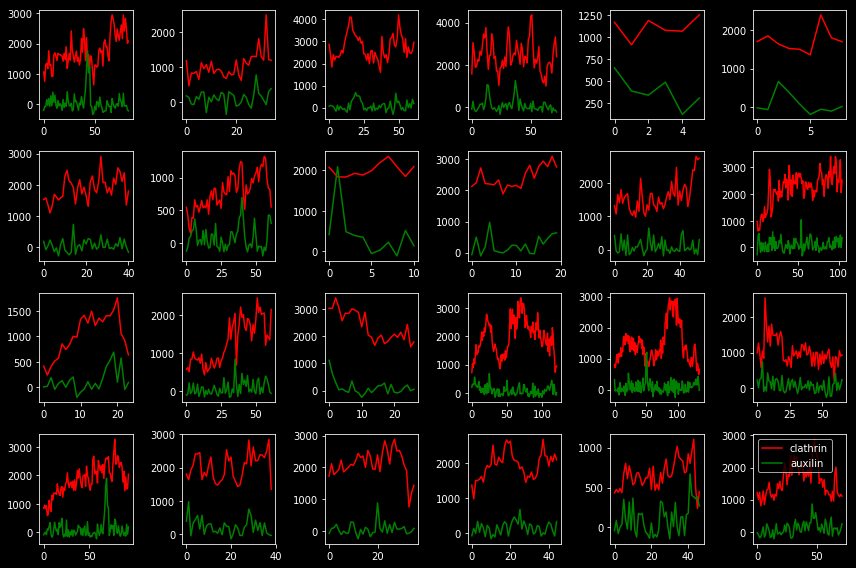

In [57]:
plt.figure(figsize=(12, 8))
R, C = 4, 6
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[early_aux_tracks[i]]
    plt.plot(row.X, color='red', label='clathrin')
    plt.plot(row.Y, color='green', label='auxilin')
#     plt.axi('off')
plt.legend()

plt.tight_layout()
plt.show()

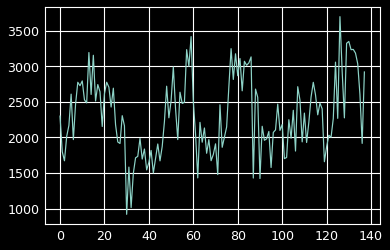

In [850]:
plt.plot(df.iloc[4515].X)